In [1]:
%matplotlib inline

In [2]:
import numpy as np
from functools import partial
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import skimage.transform as transform
from download_net import download_net

# DeepDream
This notebook demonstrates DeepDream written using TensorFlow. It accompanies the [Machine Learning at Berkeley](http://ml.berkeley.edu/) workshop "Making Art with Deep Learning", originally held October 10, 2017.

The code in this notebook was heavily adapted from [Sirajology's](https://www.youtube.com/watch?v=MrBzgvUNr4w) [DeepDream Challenge](https://github.com/llSourcell/deep_dream_challenge)


Download the inception v1 model from google's repository

In [3]:
data_dir = 'data/'
download_net(data_dir)
model_fn = 'tensorflow_inception_graph.pb'
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

Setup the tensorflow graph from the model files.

In [4]:
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(os.path.join(data_dir, model_fn), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

Enumerate the files and the features in the files. If you'd like to see a list of files, make a new cell below this one, type in `layers`, and run the cell.

In [6]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]

feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]
layers = [layer.split('/')[1] for layer in layers]
print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

Number of layers 59
Total number of feature channels: 7548


Helper code for visualization and calculating gradients.

In [7]:
def load_image(filename):
    '''
    Loads an image. 
    includes special logic for .png files which plt.imread loads to have values between 
    (0,1) and occasionally including 4 channels (4th being for alpha)
    '''
    if '.png' in filename: 
        
        img_obj = plt.imread(filename)*255
    else:
        img_obj = plt.imread(filename)
    img_obj = np.float32(img_obj)
    if len(img_obj.shape) == 3 and img_obj.shape[2] > 3:
        return img_obj[:,:,:3]
    else:
        return img_obj
def show_image(a,save=False,save_fname=None):
    ''' display the image using matplotlib'''
    plt.figure(figsize=(8,6))
    a = np.uint8(np.clip(a, 0, 255))
    plt.imshow(a)
    plt.show()
    if save:
        if save_fname is None:
            raise ValueError('save_fname must be set if save=True')
        plt.imsave(save_fname,a)

def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    img = img0.copy()
    for _ in range(iter_n):
        g, _ = sess.run([t_grad, t_score], {t_input:img})
        # normalizing the gradient, so the same step size should work
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
    showarray(visstd(img))

def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)

def calc_grad_tiled(img, t_grad, tile_size=512):
    '''
    Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over
    multiple iterations.
    '''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

Main loop code used to render deep dream. For those unfamiliar with octaves in image processing, octaves allow you to run an algorithm at different scales. Setting many octaves or large scales will allow you to make larger renders in the final image.

Experiment with different values and see what happens!

In [8]:
def render_deepdream(t_obj, 
                     img0=img_noise,
                     iter_n=10, 
                     step=1.5, 
                     octave_n=4, 
                     octave_scale=1.4, 
                     show_intermediates=True):
    '''
    Renders the Deepdream for a particular image
    and parameters
    @img0 = the image to render with deepdream
    @iter_n = the number of iterations to run for each scale. More iterations = more trippy
    @step = the size of the step along the gradient
    @octave_n = the number of octaves to render on. An octave is just a scaled down version
        This allows you to render Deepdream artifacts at larger scales
    @octave_scale = the scale to adjust per octave. 
    @show_intermediates = display the rendered results after each octave. If False only displays
        the last rendered result.
    
    returns: rendered image
    '''
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # split the image into a number of octaves
    img = img0
    octaves = []
    for _ in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)

    # generate details octave by octave
    for octave in range(octave_n):
        if octave > 0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for _ in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))

        #this will usually be like 3 or 4 octaves
        #Step 5 output deep dream image via matplotlib
        if show_intermediates:
            show_image(img)
    if not show_intermediates:
        show_image(img)
    return img

## Start the Process
Load the image here and display it.

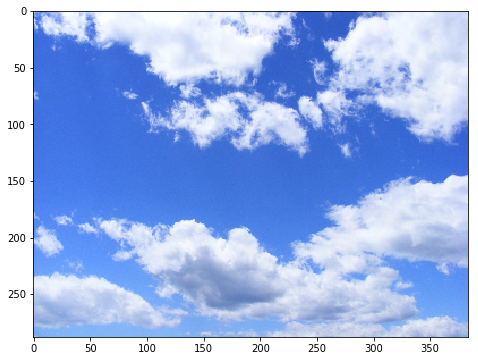

In [9]:
img0 = load_image('images/sky.jpg')
show_image(img0)

## Render Images

layer `mixed4c` captures imagery like dogs, birds, and mosques

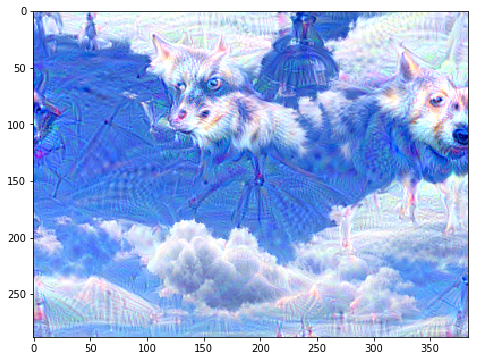

In [18]:
layer = 'mixed4c'
out_img = render_deepdream(tf.square(T(layer)), img0, octave_n=4, iter_n=20, show_intermediates=False)

Add iterations to produce a better rendering

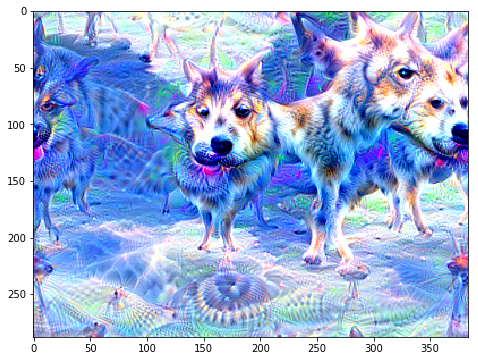

In [20]:
layer = 'mixed4c'
out_img = render_deepdream(tf.square(T(layer)), img0, octave_n=4, iter_n=100, show_intermediates=False)

Increase `octave_n` to see larger features

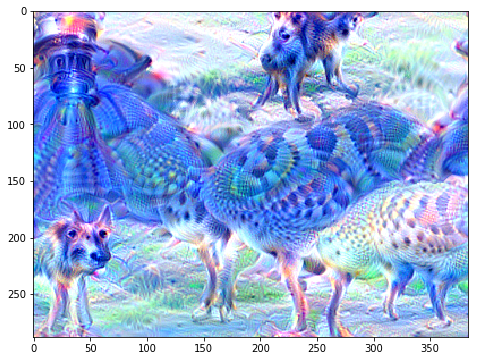

In [21]:
layer = 'mixed4c'
out_img = render_deepdream(tf.square(T(layer)), img0, octave_n=6, iter_n=50, show_intermediates=False)

Layers closer to the input have less complex features

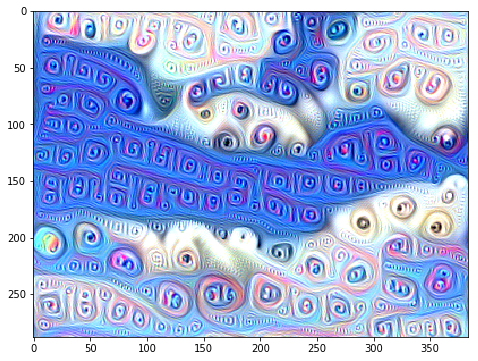

In [22]:
layer = 'mixed3b_3x3_bottleneck_pre_relu'
out_img = render_deepdream(tf.square(T(layer)), img0, octave_n=4, iter_n=100, show_intermediates=False)

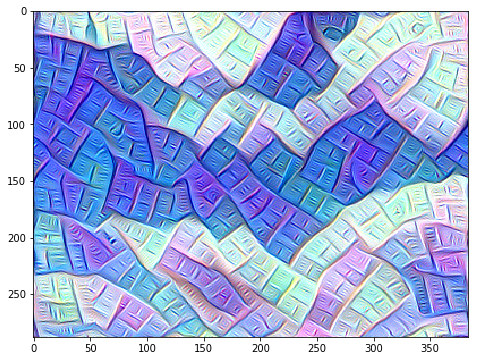

In [23]:
layer = 'mixed3a_3x3_bottleneck_pre_relu'
out_img = render_deepdream(tf.square(T(layer)), img0, octave_n=4, iter_n=100, show_intermediates=False)

Save the image to a file

In [ ]:
show_image(out_img,save=True, save_fname='deepdream.jpg')